In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import scipy.sparse as sparse

In [3]:
def get_spin(S):
    Nj = int((2*S)+1)
    Sp = sparse.csr_matrix(np.zeros((Nj,Nj), dtype = float))
    Sm = sparse.csr_matrix(np.zeros((Nj,Nj), dtype = float))
    Sz = sparse.csr_matrix(np.zeros((Nj,Nj), dtype = float))
    I = sparse.csr_matrix(np.eye(Nj, dtype = float))
    for i in range(Nj):
        Sz[i,i]=S-i
    for i in range(Nj-1):
        m=S-i-1
        Sp[i,i+1]=np.sqrt(S*(S+1)-m*(m+1))
    for i in range(Nj-1):
        m=S-i
        Sm[i+1,i]=np.sqrt(S*(S+1)-m*(m-1))
    return Sz,Sp,Sm,I
def get_H(L,p,J):
    Sz,Sp,Sm,I= get_spin(L/2)
    Sx=(Sp+Sm)/2
    #return 2*J*(L**2*I-4*Sx@Sx)+p*(-L*Sz+Sz@Sz+L**2/4*I)
    return 2*J*(L**2*I-4*Sx@Sx)-p*(Sp@Sp+L*Sz-Sz@Sz-L**2/4*I)-p*L/4*I+p/2*Sz
def get_L_red(L,p,J):
    X,Y,Z = generate_paulis(L)
    Sp=[]
    H=0
    I=sparse.csr_matrix(np.eye(2**L, dtype = float))
    for i in range(L):
        Sp.append(1/2*(X[i]+1j*Y[i]))
    for i in range(L):
        for j in range(L):
            if not(i==j):
                H+=-p*(2*Sp[i]@Sp[j]-(I-Z[i])@(I-Z[j])/4)+2*J*(I-X[i]@X[j])
    return H
    
pauli_x = sparse.csr_matrix(np.array([[0,1],[1,0]]))
pauli_y = sparse.csr_matrix(np.array([[0,-1j],[1j,0]]))
pauli_z = sparse.csr_matrix(np.array([[1,0],[0,-1]]))
I = sparse.csr_matrix(np.eye(2))

    
def generate_op_at_site(L,site,operator):
    op = I
    for i in range(L):
        if i==site:
            current_op=operator
        else:
            current_op=I
        op = sparse.kron(op,current_op, format = "csr") if i!= 0 else current_op
    return op

def generate_paulis(L):
    X=[]
    Y=[]
    Z=[]
    for i in range(L): 
        X.append(generate_op_at_site(L,i,pauli_x))
        Y.append(generate_op_at_site(L,i,pauli_y))
        Z.append(generate_op_at_site(L,i,pauli_z))
    return X,Y,Z
def generate_forward_backward(L):
    X,Y,Z = generate_paulis(L)
    Zf = []
    Xf = []
    Yf = []
        
    Zb = []
    Xb = []
    Yb = []

    I_single = sparse.csr_matrix(np.eye(2**L))
    for i in range(L):
        Xf.append(sparse.kron(I_single,X[i], format = "csr"))
        Yf.append(sparse.kron(I_single,Y[i], format = "csr"))
        Zf.append(sparse.kron(I_single,Z[i], format = "csr"))
        Xb.append(sparse.kron(X[i],I_single, format = "csr"))
        Yb.append(sparse.kron(Y[i],I_single, format = "csr"))
        Zb.append(sparse.kron(Z[i],I_single, format = "csr"))
    return Xf,Yf,Zf,Xb,Yb,Zb

def Liouvillian(L,U,J,p):
    Xf,Yf,Zf,Xb,Yb,Zb=generate_forward_backward(L)
    Spf,Spb,Smf,Smb=[],[],[],[]
    for i in range(L):
        Spf.append(1/2*(Xf[i]+1j*Yf[i]))
        Spb.append(1/2*(Xb[i]+1j*Yb[i]))
        Smf.append(1/2*(Xf[i]-1j*Yf[i]))
        Smb.append(1/2*(Xb[i]-1j*Yb[i]))
    P2=0
    I_double=sparse.csr_matrix(np.eye(2**(2*L)))
    for i in range(L):
        P2+=2*U*(I_double-Zf[i]@Zb[i])
    for i in range(L):
        for j in range(L):
            P2+= +2*J*(I_double-Xf[i]@Xb[i]@Xf[j]@Xb[j])
            P2+= -p*(2*Spf[i]@Spf[j]@Spb[i]@Spb[j]-Smf[i]@Smf[j]@Spf[i]@Spf[j]-Smb[i]@Smb[j]@Spb[i]@Spb[j])
    
    return P2

In [5]:
ps = np.linspace(0,20,20)
#ps=[0]
Ls = [4,8,12]
#Ls=[4]
cors = np.zeros((len(Ls),len(ps)))
for i,L in enumerate(Ls):
    #Sz,Sp,Sm,I=get_spin(L/2)
    #X=Sp+Sm
    X,Y,Z= generate_paulis(L)

    all_up=np.zeros(2**L)
    all_up[0]=1
    for j,p in enumerate(ps):
        print(p)
        H=get_L_red(L,p,1)
        v=all_up.copy()
        for t in np.linspace(0,10,10):
            v=sparse.linalg.expm_multiply(-1*H,v)
            v=v/np.linalg.norm(v)
        cors[i,j]=v.transpose().conj()@X[0]@X[int(L/2)]@v
print(cors)

0.0
1.0526315789473684


C:\Users\nzier\AppData\Local\Temp\ipykernel_52188\1475311632.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  cors[i,j]=v.transpose().conj()@X[0]@X[int(L/2)]@v


2.1052631578947367
3.1578947368421053
4.2105263157894735
5.263157894736842
6.315789473684211
7.368421052631579
8.421052631578947
9.473684210526315
10.526315789473683
11.578947368421051
12.631578947368421
13.68421052631579
14.736842105263158
15.789473684210526
16.842105263157894
17.894736842105264
18.94736842105263
20.0
0.0
1.0526315789473684
2.1052631578947367
3.1578947368421053
4.2105263157894735
5.263157894736842
6.315789473684211
7.368421052631579
8.421052631578947
9.473684210526315
10.526315789473683
11.578947368421051
12.631578947368421
13.68421052631579
14.736842105263158
15.789473684210526
16.842105263157894
17.894736842105264
18.94736842105263
20.0
0.0
1.0526315789473684
2.1052631578947367
3.1578947368421053
4.2105263157894735
5.263157894736842
6.315789473684211
7.368421052631579
8.421052631578947
9.473684210526315
10.526315789473683
11.578947368421051
12.631578947368421
13.68421052631579
14.736842105263158
15.789473684210526
16.842105263157894
17.894736842105264
18.94736842105

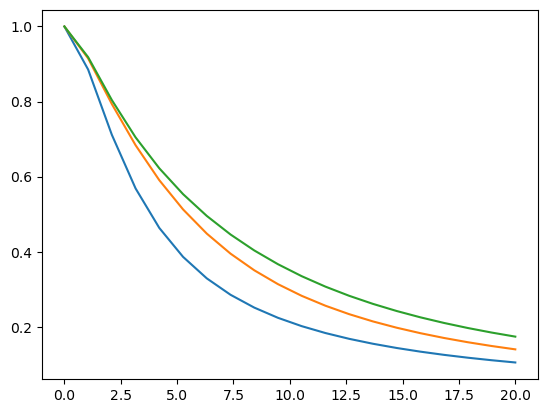

In [7]:
fig, ax= plt.subplots(1)
ax.plot(ps, cors[0,:])
ax.plot(ps, cors[1,:])
ax.plot(ps, cors[2,:])

In [18]:
ps = np.linspace(0,40,30)
#ps=[0]
Ls = [8]
#ps =[40]
#Ls=[4]
cors = np.zeros((len(Ls),len(ps)))
for i,L in enumerate(Ls):
    print(L)
    Sz,Sp,Sm,I=get_spin(L/2)
    X=Sp+Sm
    all_up=np.zeros(L+1)
    all_up[0]=1
    for j,p in enumerate(ps):
        print(p)
        H=get_H(L,p,1)
        v=all_up.copy()
        Nt=40
        Tmax=1
        for t in np.linspace(0,Tmax,Nt):
            #print(np.linalg.norm(v))
            v=sparse.linalg.expm_multiply(-Tmax/Nt*H,v)
            #print(np.linalg.norm(v))
            v=v/np.linalg.norm(v)
        cors[i,j]=v.transpose().conj()@X@X@v/L**2
print(cors)

8
0.0
1.3793103448275863
2.7586206896551726
4.137931034482759
5.517241379310345
6.8965517241379315
8.275862068965518
9.655172413793103
11.03448275862069
12.413793103448278
13.793103448275863
15.172413793103448
16.551724137931036
17.931034482758623
19.310344827586206
20.689655172413794
22.06896551724138
23.448275862068968
24.827586206896555
26.20689655172414
27.586206896551726
28.965517241379313
30.344827586206897
31.724137931034484
33.10344827586207
34.48275862068966
35.862068965517246
37.24137931034483
38.62068965517241
40.0
[[1.         0.93832851 0.84323326 0.75431123 0.6763988  0.60922493
  0.55179095 0.50293942 0.46148187 0.4262861  0.39633367 0.37074466
  0.34877861 0.32982241 0.31337294 0.29901906 0.28642502 0.27531629
  0.26546768 0.25669384 0.24884146 0.24178318 0.23541262 0.22964052
  0.22439161 0.21960206 0.21521757 0.21119163 0.20748431 0.20406114]]


In [21]:
cor_new0=[1.,         0.93832851, 0.84323326, 0.75431123, 0.6763988,  0.60922493,
  0.55179095, 0.50293942, 0.46148187, 0.4262861 , 0.39633367, 0.37074466,
  0.34877861, 0.32982241, 0.31337294, 0.29901906, 0.28642502, 0.27531629,
  0.26546768, 0.25669384, 0.24884146, 0.24178318, 0.23541262, 0.22964052,
  0.22439161, 0.21960206, 0.21521757, 0.21119163, 0.20748431, 0.20406114]

cor_new1=[1.         ,0.93632468, 0.83879174, 0.75002346, 0.67523674, 0.61285854,
  0.56040557, 0.51572423, 0.47716745, 0.44352066, 0.41389007, 0.38760796,
  0.3641636 , 0.34315581, 0.32426128, 0.30721362, 0.29178932, 0.27779822,
  0.26507689, 0.25348377, 0.24289562, 0.23320465, 0.22431632, 0.21614753,
  0.20862502, 0.20168413, 0.19526768, 0.18932499, 0.18381112, 0.17868609]

cor_new2=[1.,         0.93529407, 0.8361117,  0.74577318, 0.66969197, 0.60643852,
  0.55363052, 0.50913698, 0.47125681, 0.4386716  ,0.41036393, 0.38554517,
  0.36359967, 0.34404295, 0.32649075, 0.31063589 ,0.29623096 ,0.28307516,
  0.27100426, 0.25988291, 0.2495987 , 0.24005751 ,0.23117994 ,0.22289847,
  0.21515526, 0.20790036, 0.20109034, 0.19468719 ,0.1886574  ,0.1829713]

cor_new3=[1.,         0.93477506, 0.83476047, 0.74361901, 0.6668221,  0.6029414,
  0.54958502, 0.50461361, 0.46632216, 0.43339268, 0.40481078, 0.3797916,
  0.3577223 , 0.33811933, 0.32059706, 0.30484472, 0.29060939, 0.27768331,
  0.2658943 , 0.25509857, 0.24517513, 0.23602149, 0.2275503 , 0.21968667,
  0.21236609, 0.2055327 , 0.19913795, 0.19313942, 0.18749995, 0.18218686]

cor_new4=[1.,         0.9345147,  0.83408239, 0.74253765, 0.66538102, 0.60118471,
  0.54755141 ,0.50233572, 0.46382734, 0.43070386, 0.40194736, 0.37677011,
  0.35455702 ,0.33482277, 0.31718041, 0.30131823, 0.28698265, 0.27396552,
  0.2620945  ,0.25122577, 0.24123841, 0.23203007, 0.22351355, 0.21561412,
  0.20826739 ,0.20141757, 0.1950161,  0.18902052, 0.18339354, 0.17810227]

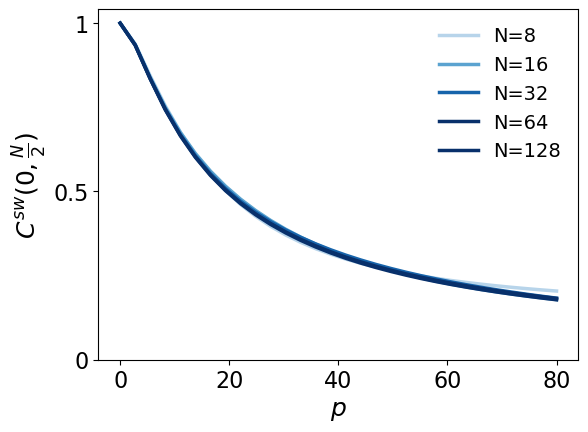

In [23]:
fig, ax = plt.subplots(1)
colors = plt.get_cmap("Blues")(np.linspace(0.3, 1.3, 5))
ax.plot(ps*2, cor_new0[:], color=colors[0], label = "N=8", linewidth=2.5)
ax.plot(ps*2, cor_new1[:], color=colors[1], label = "N=16", linewidth=2.5)
ax.plot(ps*2, cor_new2[:], color=colors[2], label = "N=32", linewidth=2.5)
ax.plot(ps*2, cor_new3[:], color=colors[3], label = "N=64", linewidth=2.5)
ax.plot(ps*2, cor_new4[:], color=colors[4], label = "N=128", linewidth=2.5)
#ax.plot(ps*2, cor4[:], color=colors[3], label = "L=64", linewidth=2.5)
#ax.plot(ps*2, cor5, color=colors[4], label = "L=128", linewidth=2.5)
ax.legend(fontsize = 14, frameon = False)
ax.set_xlabel(r"$p$", fontsize = 18)

ax.set_yticks([0,0.5,1])
ax.set_xticks([0,20,40,60,80])
ax.set_yticklabels(["0","0.5","1"])
ax.tick_params(labelsize = 16)

plt.gcf().subplots_adjust(left=0.15)
plt.gcf().subplots_adjust(bottom=0.15)


ax.set_ylabel(r"$C^{sw}(0,\frac{N}{2})$", fontsize = 18)
fig.savefig(r"C:\Users\nzier\Documents\QuantumActiveMatter\QuantumCircuits\figs\Adaptive_Rényi2.pdf", format = "pdf")

In [2]:
cor1=[1.         ,0.88067765, 0.7322207 , 0.60980398, 0.5138109 , 0.44046739,
  0.3849238,  0.34269156 ,0.31021621 ,0.2848775 , 0.26479832, 0.24864291,
  0.23545637, 0.22454917, 0.21541702, 0.20768608, 0.2010754 , 0.19537097,
  0.19040774, 0.18605682]
cor2= [1.         ,0.88120215 ,0.7379459,  0.627053   ,0.54246666 ,0.47607457,
  0.42246738 ,0.37829924 ,0.34142427, 0.31036453 ,0.28403034 ,0.26157841,
  0.24233729 ,0.22576435 ,0.21141775 ,0.1989363  ,0.18802386 ,0.17843705,
  0.16997523 ,0.16247246]
cor3= [1.         ,0.88118122, 0.73757301 ,0.62642761, 0.54243033 ,0.47775506,
  0.42673169 ,0.38552568, 0.35153699 ,0.32297496, 0.29858487 ,0.2774721,
  0.25898733 ,0.2426505 , 0.22809971 ,0.21505668, 0.20330316, 0.19266465,
  0.18299911 ,0.17418905]

cor4=[1.         ,0.88114531, 0.73731155, 0.62581741, 0.54142972, 0.47637747,
  0.42504189 ,0.38363794, 0.34960284, 0.32116339, 0.29706197, 0.27638511,
  0.25845461 ,0.24275711, 0.22889728, 0.21656611, 0.20551891, 0.19555969,
  0.18652989 ,0.17830008]

cor5=[1.         ,0.88112149, 0.73716751, 0.62549278, 0.5409032,  0.47564727,
  0.4241149  ,0.38252461, 0.34831496, 0.31971344, 0.29546318, 0.27465189,
  0.256603   ,0.24080499, 0.22686438, 0.21447379, 0.20338975, 0.19341697,
  0.18439705 ,0.17620018]
ps = np.linspace(0,40,20)

In [4]:
L=1
Xf,Yf,Zf,Xb,Yb,Zb=generate_forward_backward(L)
Spf,Spb,Smf,Smb=[],[],[],[]
for i in range(L):
    Spf.append(1/2*(Xf[i]+1j*Yf[i]))
    Spb.append(1/2*(Xb[i]+1j*Yb[i]))
    Smf.append(1/2*(Xf[i]-1j*Yf[i]))
    Smb.append(1/2*(Xb[i]-1j*Yb[i]))
v=np.zeros(2**(2*L))
v[3]=1
Smf[0]@Spf[0]@v

NameError: name 'generate_forward_backward' is not defined

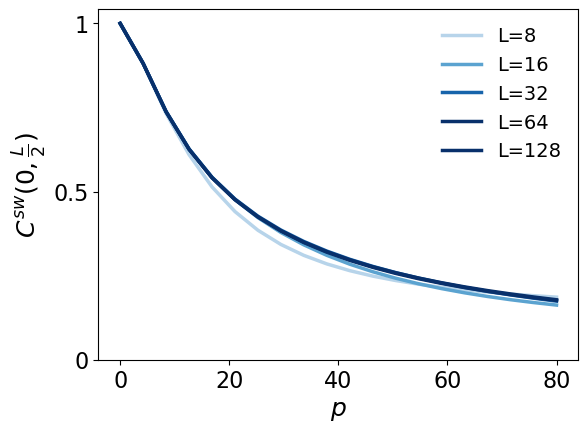

In [8]:
fig, ax = plt.subplots(1)
colors = plt.get_cmap("Blues")(np.linspace(0.3, 1.3, 5))
ax.plot(ps*2, cor1[:], color=colors[0], label = "L=8", linewidth=2.5)
ax.plot(ps*2, cor2[:], color=colors[1], label = "L=16", linewidth=2.5)
ax.plot(ps*2, cor3[:], color=colors[2], label = "L=32", linewidth=2.5)
ax.plot(ps*2, cor4[:], color=colors[3], label = "L=64", linewidth=2.5)
ax.plot(ps*2, cor5, color=colors[4], label = "L=128", linewidth=2.5)
ax.legend(fontsize = 14, frameon = False)
ax.set_xlabel(r"$p$", fontsize = 18)

ax.set_yticks([0,0.5,1])
ax.set_xticks([0,20,40,60,80])
ax.set_yticklabels(["0","0.5","1"])
ax.tick_params(labelsize = 16)

plt.gcf().subplots_adjust(left=0.15)
plt.gcf().subplots_adjust(bottom=0.15)


ax.set_ylabel(r"$C^{sw}(0,\frac{L}{2})$", fontsize = 18)
fig.savefig(r"C:\Users\nzier\Documents\QuantumActiveMatter\QuantumCircuits\figs\Adaptive_Rényi2.pdf", format = "pdf")

In [521]:
Ls=[2,4]



ps=np.linspace(0,10,10)
cors = np.zeros((len(Ls),len(ps)))

for i,L in enumerate(Ls):
    Xf,Yf,Zf,Xb,Yb,Zb=generate_forward_backward(L)
    print(L)
    all_up=np.zeros(2**(2*L))
    all_up[0]=1
    for j,p in enumerate(ps):
        print(p)

        H = Liouvillian(L,1,1,p)
        v=sparse.linalg.expm_multiply(-10*H,all_up)
       # E,v=sparse.linalg.eigsh(H.conj().transpose()@H, k=2, which = "SR")
        #sorted_indices = np.argsort(E)  # sorts from smallest to largest
        #smallest_two_indices = sorted_indices[:2]
    
        # Get the corresponding eigenvectors
        #v = vs[:, smallest_two_indices]
       # print(v[:,0])
        #print(v[:,1])
        #print(E[smallest_two_indices])
    
        #cors1.append(np.abs(v[:,0].transpose().conj()@Xf[0]@Xb[0]@Xf[L-1]@Xb[L-1]@v[:,0]))
        #cors2.append(np.abs(v[:,1].transpose().conj()@Xf[0]@Xb[0]@Xf[L-1]@Xb[L-1]@v[:,1]))
        #v_new = v[:,0]*(v[:,0].transpose().conj()@all_up)+v[:,1]*(v[:,1].transpose().conj()@all_up)
        v = v/np.linalg.norm(v)
        cors[i,j]=np.abs(v.transpose().conj()@Xf[0]@Xb[0]@Xf[L-1]@Xb[L-1]@v)
    print()

2
0.0
1.1111111111111112
2.2222222222222223
3.3333333333333335
4.444444444444445
5.555555555555555
6.666666666666667
7.777777777777779
8.88888888888889
10.0

4
0.0
1.1111111111111112
2.2222222222222223
3.3333333333333335
4.444444444444445
5.555555555555555
6.666666666666667
7.777777777777779
8.88888888888889
10.0



In [13]:
import gc
gc.collect()

1624

In [15]:
N=20
Ls=np.array([16])
ps = np.linspace(0,80,N)
fid_cor=np.zeros((4,N))
trace_var = np.zeros((4,N))
trace = np.zeros((4,N))
for i,L in enumerate(Ls):
    print(L)
    X,Y,Z = generate_paulis(L)
    for j,p in enumerate(ps):   
        print(p)
        H=get_L_red(L,p,1)
        all_up=np.zeros(2**L)
        all_up[0]=1
        state=all_up.copy()
        Nt =10
        Tmax = 2
        for t in np.linspace(0,Tmax,Nt):
            state=sparse.linalg.expm_multiply(-Tmax/Nt*H,state)
            state=state/np.linalg.norm(state)
        trace_var[i,j]=2**(L-1)-np.sum(np.abs(state))
        trace[i,j]=np.sum(np.abs(state))
        sqrt_state = np.sqrt(np.abs(state[:]))
        density = sc.sparse.diags(np.abs(state[:]),0)
        density_trans = (X[0]@X[int(L/2)]@density@X[int(L/2)]@X[0])
        sigma_rho = (density@density_trans).diagonal()
        
        #sigma_sqrt = sc.sparse.diags(np.sqrt(density_trans))
        fid=(np.sqrt(sigma_rho)).sum()/trace[i,j]
        fid_cor[i,j]=fid
    print()

16
0.0


KeyboardInterrupt: 

In [9]:
fid_cor=np.array([[1.        , 0.8779852 , 0.77466844, 0.70034426, 0.64382008,
        0.59892094, 0.5620998 , 0.53116839, 0.50469374, 0.48169183,
        0.46146063, 0.44348347, 0.42737015, 0.41281948, 0.39959466,
        0.38750647, 0.37640162, 0.36615434, 0.35666035, 0.34783234],
       [1.        , 0.8959621 , 0.81061798, 0.74767166, 0.69825916,
        0.65781811, 0.62375803, 0.59446843, 0.56887809, 0.54623739,
        0.52600081, 0.50775881, 0.49119614, 0.47606495, 0.46216698,
        0.4493412 , 0.43745512, 0.42639851, 0.41607869, 0.40641707],
       [1.        , 0.89671405, 0.81354411, 0.75338781, 0.70682094,
        0.66904339, 0.63738105, 0.61020764, 0.58646488, 0.5654271 ,
        0.54657567, 0.52952731, 0.51399087, 0.49974002, 0.48659538,
        0.47441231, 0.46307256, 0.45247814, 0.44254701, 0.43320974],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]])

In [10]:
fid_cor

array([[1.        , 0.8779852 , 0.77466844, 0.70034426, 0.64382008,
        0.59892094, 0.5620998 , 0.53116839, 0.50469374, 0.48169183,
        0.46146063, 0.44348347, 0.42737015, 0.41281948, 0.39959466,
        0.38750647, 0.37640162, 0.36615434, 0.35666035, 0.34783234],
       [1.        , 0.8959621 , 0.81061798, 0.74767166, 0.69825916,
        0.65781811, 0.62375803, 0.59446843, 0.56887809, 0.54623739,
        0.52600081, 0.50775881, 0.49119614, 0.47606495, 0.46216698,
        0.4493412 , 0.43745512, 0.42639851, 0.41607869, 0.40641707],
       [1.        , 0.89671405, 0.81354411, 0.75338781, 0.70682094,
        0.66904339, 0.63738105, 0.61020764, 0.58646488, 0.5654271 ,
        0.54657567, 0.52952731, 0.51399087, 0.49974002, 0.48659538,
        0.47441231, 0.46307256, 0.45247814, 0.44254701, 0.43320974],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0

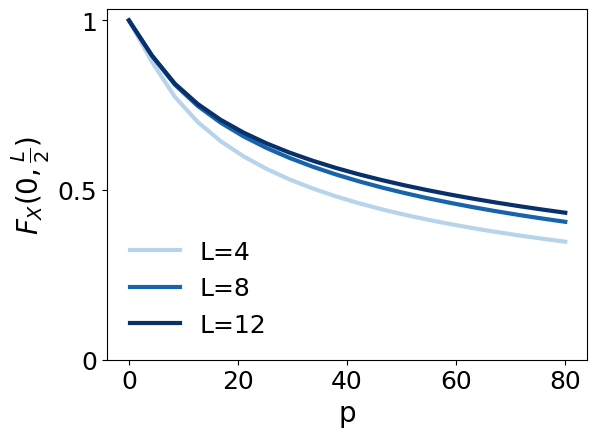

In [21]:
fig, ax = plt.subplots(1)
colors = plt.get_cmap("Blues")(np.linspace(0.3, 1.3, 3))
ax.plot(2*ps,fid_cor[0,:], color = colors[0], label = "L=4", linewidth = 3)
ax.plot(2*ps,fid_cor[1,:], color = colors[1], label = "L=8", linewidth = 3)
ax.plot(2*ps,fid_cor[2,:], color = colors[2], label = "L=12", linewidth = 3)
#ax.plot(ps,fid_cor[3,:])
ax.legend(fontsize = 18, frameon = False, loc = "lower left")

ax.set_yticks([0,0.5,1])
ax.set_xticks([0,20,40,60,80])
ax.set_yticklabels(["0","0.5","1"])
ax.tick_params(labelsize = 18)

ax.set_ylabel(r"$F_X(0,\frac{L}{2})$", fontsize = 20)

ax.set_xlabel(r"p", fontsize = 20)

plt.gcf().subplots_adjust(left=0.15)
plt.gcf().subplots_adjust(bottom=0.15)

fig.savefig(r"C:\Users\nzier\Documents\QuantumActiveMatter\QuantumCircuits\figs\Adaptive_Fidelity.pdf", format = "pdf")